# HMM Tutorial 1: Markov Models

Ultimately, this package is about simulating and inferring properties of Hidden Markov Models, which are simply probabilitistic functions of an underlying markov model. In this notebook we go through the somewhat simpler process of simulating dynamics on a Markov model.  Here, we assume that we have a discrete state space with $N$ states. The probability of transitioning from state $i\to j$ in a time interval $\Delta t$ is given by the element $A_{ij}$ of the transition matrix (which will be $N\times N$) in shape. Therefore we can describe the evolution in time of an initial ($N\times 1$)probability vector $p_0$ by the matrix multiplication by $\boldsymbol{A}$ so that

$$ p_1 = \boldsymbol{A} \cdot p_0 $$

It then follows that to propagate the dynamics $T$ time intervals we simply repeat the above process so that

$$ p_T = \boldsymbol{A}^T \cdot p_0$$

Eventually, the probability will relax into a steady state (so long as the transition matrix elements are constant in time) so that the condition 

$$ p_{\rm ss} = \boldsymbol{A} \cdot p_{\rm ss}$$

*i.e.* the transition matrix has no impact on the probability vector. Based on the siilarity of this expression with the eigenvalue-eigenvector equation, it follows that the stationary probability distribution is simply the (right) eigenvector of the transition matrix, with eigenvalue $1$.

Now, while this rather simple picture describes the evolution of the probability distribution, simulating a given trajectory is more tricky. To do this, we make use of a kinetic Monte Carlo scheme, which probabilistically draws the next state in the sequence of system states in such a way that the long-term distribution staisfies the above equation for the steady state, and the statistical transition probabilities are consistent with the transition rate matrix $\boldsymbol{A}$.

In this notebook, we will show how to initialize a Markov model of a few different dimensions, calculate the steady-state probabbility distribution, and also simulate a trajectory of those dynamics.


In [2]:
# to start, import the hidden.dynamics module, as well as some other necessary
# libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from hidden import dynamics

# Now, we can initialize a hidden markov model with 2-states
mm = dynamics.HMM(2, 2)

In [3]:
# Now, we can set the A-matrix
A = np.array([[0.95, 0.1], [0.05, 0.9]])
# And for a Markov model, we can think of it as a hidden markov model with no
# observation errors, which means that the B matrix is the itentity
B = np.eye(2)

mm.initialize_dynamics(A, B)

# WE cna show that the attribute mm.A is, in fact the matrix we set
mm.A, mm.B

(array([[0.95, 0.1 ],
        [0.05, 0.9 ]]),
 array([[1., 0.],
        [0., 1.]]))

In [4]:
# Now, we can calculate the steady-state distribution from the eigenvalue spectrum
e_vals, e_vecs = np.linalg.eig(A)
# And show that one of the eigenvalues is, in fact, 1
e_vals

array([1.  , 0.85])

In [5]:
# And the corresponding eigenvalue (after normalization) is the steady-state
steady_state = e_vecs[:, 0] / np.sum(e_vecs[:, 0])
steady_state

array([0.66666667, 0.33333333])

In [5]:
# We can also get this steady state simply from the property on the mm object
mm.steady_state

array([0.66666667, 0.33333333])

In [6]:
# Now, to run the simulated dynamics, we simply call the 'run_dynamics' function
mm.run_dynamics(n_steps = 5000)

In [7]:
# Now, we can get the trajectory of states through the following
state_ts = mm.get_state_ts()

# Lets look at the first 10 states of the trajectory
state_ts[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

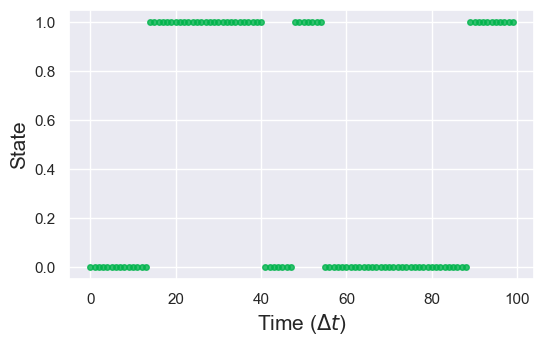

In [10]:
# Or, we can plot the states over time as:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

# So we dont crownd things, lets just look at the first 100 states
ax.plot(state_ts[:100], 'o', markersize=4, color=sns.xkcd_rgb["shamrock"], alpha=0.8)
ax.set_xlabel(r"Time ($\Delta t$)", fontsize=15)
ax.set_ylabel(r"State", fontsize=15)
plt.savefig("ts.png")
plt.show()

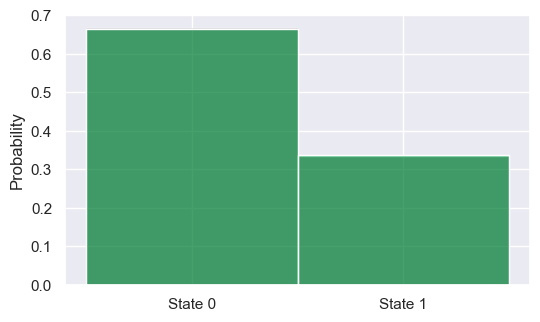

In [11]:
# From the full trajectory, we can also plot an empirical probability distribution
# that should look alot like the steady-state distribution

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

# first, make a bar chart of the steady-state ditribution
ax.bar([0, 1], mm.steady_state, color='k', alpha=0.5, width=1.0)
# And then a histogram of the observed state probabilities
binEdges = [-0.5, 0.5, 1.5]
sns.histplot(state_ts, stat="probability", color=sns.xkcd_rgb["shamrock"], alpha=0.5, bins=binEdges)

ax.set_xticks([0, 1])
ax.set_xticklabels(['State 0', "State 1"])
plt.savefig("steady.png")
plt.show()


In [46]:
# We see from the above chart that the empirical distribution matches the
# expectatation: the steady state distribution from A

# Finally, we can estimate the elements of A from the observed number of
# transitions into and out of each state

# For the 0 -> 1 transition, we want to find (# of transitions OUT of state 0) / (number of times IN state zero)

numer = len(np.array(state_ts[1:])[(np.diff(state_ts) > 0)]) 
# ts[1] theke start hoise kenona 0 theke start hole tar difference nile NA ashto. r ts>0 dise kenona  sudhu tahole 1 value count hobe
denom = len(np.array(state_ts)[np.isclose(state_ts, 0)]) # jotogulo 0 ase tar number

A_10 = numer / denom
A_10

0.05188199389623601

In [48]:
# And then for the other off-diagonal element
numer = len(np.array(state_ts[1:])[(np.diff(state_ts) < 0)])
denom = len(np.array(state_ts)[np.isclose(state_ts, 1)])

A_01 = numer / denom
A_01

0.09864603481624758

In [49]:
# And we can use this (along with the fact that conservation of probability
# requires that the columns of A sum to 1) to build our estimated matrix:

A_est = np.array([[1 - A_10, A_01], [A_10, 1 - A_10]])
# A_10, A_01 diye amra A matrix er diagonal element gulo nilam tae off diagonal ber korar jonno amra 1 theke minus korlam, kenona columnwise sum hobe zero.
A_est, mm.A

(array([[0.94811801, 0.09864603],
        [0.05188199, 0.94811801]]),
 array([[0.95, 0.1 ],
        [0.05, 0.9 ]]))

In [50]:
# So, in summary, in this notebook we shoed:
#
# - How to initialize a markov model
# - How to calcualte the steady-state probability vector
# - How to run dynamics of the model
# - How to plot the empirical probability distirubtion
# - How to estimate the transition matrix elements from observed transitions